<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/correlated_datums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

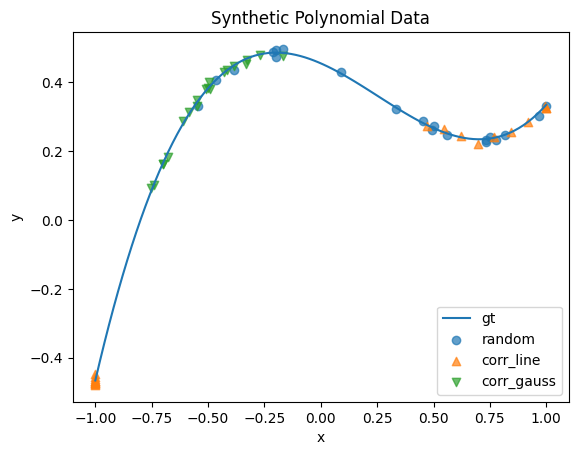

In [64]:
import itertools
from dataclasses import dataclass
from typing import Tuple, List, Optional

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)


@dataclass
class RandomPolynomialDataGenerator:
    """
    Generate synthetic data (X, y) from a randomly generated polynomial.

    - Input: 1 or 2 variables (configurable via input_dim).
    - Output: 1 variable (y).
    - Output is: y = P(x) + noise, where P is a random polynomial.
    """
    input_dim: int = 1          # 1 or 2
    degree: int = 3             # maximum total degree of the polynomial
    coeff_range: Tuple[float, float] = (-1.0, 1.0)
    x_range: Tuple[float, float] = (-1.0, 1.0)
    noise_std: float = 0.001
    random_state: Optional[int] = None

    def __post_init__(self):
        if self.input_dim not in (1, 2):
            raise ValueError("input_dim must be 1 or 2")

        self.rng = np.random.default_rng(self.random_state)
        self.monomials = self._generate_monomials(self.input_dim, self.degree)
        self.coeffs = self._sample_coeffs()

    @staticmethod
    def _generate_monomials(input_dim: int, degree: int) -> List[Tuple[int, ...]]:
        """
        Generate all exponent tuples (e1, ..., ed) such that:
            e1 + ... + ed <= degree and each ei >= 0.
        """
        exponents = []
        for total_deg in range(degree + 1):
            # All non-negative integer solutions to sum(e) == total_deg
            # using product and filtering.
            for exp in itertools.product(range(total_deg + 1), repeat=input_dim):
                if sum(exp) == total_deg:
                    exponents.append(exp)
        return exponents

    def _sample_coeffs(self) -> np.ndarray:
        low, high = self.coeff_range
        return self.rng.uniform(low, high, size=len(self.monomials))

    def resample_polynomial(self):
        """
        Resample the polynomial coefficients while keeping the same monomial structure.
        """
        self.coeffs = self._sample_coeffs()

    def _evaluate_polynomial(self, X: np.ndarray) -> np.ndarray:
        """
        Evaluate the random polynomial at points X.

        X: shape (n_samples, input_dim)
        Returns: y of shape (n_samples,)
        """
        X = np.atleast_2d(X)
        if X.shape[1] != self.input_dim:
            raise ValueError(f"Expected X with shape (n_samples, {self.input_dim}), got {X.shape}")

        y = np.zeros(X.shape[0], dtype=float)
        for coeff, exps in zip(self.coeffs, self.monomials):
            # Compute term = coeff * prod_j x_j ** exps[j]
            term = coeff * np.prod(X ** np.array(exps), axis=1)
            y += term
        return y

    def random_sample(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Sample X and y from the random polynomial with Gaussian noise.

        Returns:
            X: np.ndarray of shape (n_samples, input_dim)
            y: np.ndarray of shape (n_samples,)
        """
        x_low, x_high = self.x_range
        X = self.rng.uniform(x_low, x_high, size=(n_samples, self.input_dim))
        y_clean = self._evaluate_polynomial(X)
        noise = self.rng.normal(loc=0.0, scale=self.noise_std, size=n_samples)
        y = y_clean + noise
        return X, y

    def correlated_sample(self, n_samples, n_seeds, x_range_shrinkage: float = 0.1, linear: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        x_low, x_high = self.x_range
        seeds_X = self.rng.uniform(x_low, x_high, size=(n_seeds, self.input_dim))
        num_samples_per_seed = n_samples // n_seeds
        maybe_samples_x = seeds_X.reshape(n_seeds, 1, self.input_dim)
        radius_around_seeds_X = ((x_high - x_low) * x_range_shrinkage) / 2
        samples_X = np.tile(seeds_X, (1, num_samples_per_seed, 1))
        if linear:
            frac = (
                np.arange(num_samples_per_seed) / (num_samples_per_seed - 1)
            ).reshape(1, num_samples_per_seed, 1).repeat(n_seeds, axis=1)
            seed_low = samples_X - radius_around_seeds_X
            seed_high = samples_X + radius_around_seeds_X
            X = seed_low + frac * seed_high

        else:
            # gaussian sample
            X = samples_X + radius_around_seeds_X * self.rng.normal(size=samples_X.shape)
        X = np.clip(X, x_low, x_high)
        X = X.reshape(-1, self.input_dim)
        y_clean = self._evaluate_polynomial(X)
        noise = self.rng.normal(loc=0.0, scale=self.noise_std, size=n_samples)
        y = y_clean + noise
        return X, y

    def get_X(self, num_points, verbose: bool = False):
        if self.input_dim == 1:
            X = np.arange(num_points) / (num_points - 1)
            low, high = self.x_range
            range = high - low
            X = low + range * X
            X = X.reshape(-1, self.input_dim)

            return X
        else:
            return None

    def draw_line(self, ax, num_points: int = 100, verbose: bool = False):
        X = self.get_X(num_points)
        if self.input_dim == 1:
            y_clean = self._evaluate_polynomial(X)
            ax.plot(X, y_clean, label="gt")
        elif verbose:
            print(f"line for {self.input_dim} not supported")

def plot_polynomial_data(X: np.ndarray, y: np.ndarray, label: str = "", marker: str = "o", title: str = "Synthetic Polynomial Data", ax=None):
    """
    Plot synthetic polynomial data.

    - If X has shape (n_samples,) or (n_samples, 1): 2D scatter (x vs y).
    - If X has shape (n_samples, 2): 3D scatter (x1, x2 vs y).

    Args:
        X: np.ndarray, shape (n_samples,) or (n_samples, 1 or 2)
        y: np.ndarray, shape (n_samples,)
        title: plot title
    """
    X = np.asarray(X)
    y = np.asarray(y)

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples")

    if X.shape[1] == 1:
        # 2D scatter plot
        if ax is None:
            fig, ax = plt.subplots()
        ax.scatter(X[:, 0], y, alpha=0.7, label=label, marker=marker)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(title)
        # plt.show()

    elif X.shape[1] == 2:
        # 3D scatter plot
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
        ax.scatter(X[:, 0], X[:, 1], y, alpha=0.7, label=label, marker=marker)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("y")
        ax.set_title(title)
        # plt.show()

    else:
        raise ValueError("plot_polynomial_data only supports 1D or 2D inputs (input_dim 1 or 2).")


generator = RandomPolynomialDataGenerator(noise_std=0.01)
n_samples = 20
n_seeds = 2
x_random, y_random = generator.random_sample(n_samples)
x_corr_line, y_corr_line = generator.correlated_sample(n_samples, n_seeds, linear=True)
x_corr_gauss, y_corr_gauss = generator.correlated_sample(n_samples, n_seeds, linear=False)

fig, ax = plt.subplots()
generator.draw_line(ax)
plot_polynomial_data(x_random, y_random, label="random", ax=ax, marker="o")
plot_polynomial_data(x_corr_line, y_corr_line, label="corr_line", ax=ax, marker="^")
plot_polynomial_data(x_corr_gauss, y_corr_gauss, label="corr_gauss", ax=ax, marker="v")
plt.legend(loc="best")
plt.show()

In [72]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import flax.nnx as nnx
from typing import Callable
import functools as ft
from IPython.display import clear_output


class MLP(nnx.Module):
    """Simple MLP for y = f(x) regression."""
    def __init__(self, in_dim: int, hidden_dims, out_dim: int = 1, rngs: nnx.Rngs = nnx.Rngs(0)):
        self.layers = []
        last_dim = in_dim
        for h in hidden_dims:
            self.layers.append(nnx.Linear(last_dim, h, rngs=rngs))
            last_dim = h
        self.layers.append(nnx.Linear(last_dim, out_dim, rngs=rngs))

    def __call__(self, x: jax.Array) -> jax.Array:
        x = jnp.asarray(x)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = jax.nn.tanh(x)
        return x

# -------------------------------------------------------------------------
# Loss and train step
# -------------------------------------------------------------------------
def loss_fn(model, xb, yb):
    preds = model(xb).squeeze(-1)
    return jnp.mean((preds - yb) ** 2)

@nnx.jit
def train_step(model, optimizer, xb, yb):
    def _loss(m):
        return loss_fn(m, xb, yb)

    loss, grads = nnx.value_and_grad(_loss)(model)
    optimizer.update(grads)
    return loss


def train_polynomial_regressor(
    sample_fn: Callable[[int], tuple[np.ndarray, np.ndarray]],          # instance of RandomPolynomialDataGenerator
    hidden_dims=(64, 64),
    lr: float = 1e-2,
    num_steps: int = 2000,
    batch_size: int = 128,
    log_every: int = 50,
    seed: int = 0,
):
    """
    1. Sample (X, y) from data_generator
    2. Build an MLP (Flax NNX) to predict y from X
    3. Train with SGD (via optax.sgd)
    4. Plot loss every `log_every` steps

    Returns:
        model: trained MLP (flax.nnx.Module)
        optimizer: final nnx.Optimizer
        loss_history: list of logged loss values
    """
    # -------------------------------------------------------------------------
    # Data
    # -------------------------------------------------------------------------
    X, _ = sample_fn(batch_size)
    _, in_dim = X.shape

    # -------------------------------------------------------------------------
    # Model + optimizer
    # -------------------------------------------------------------------------
    rngs = nnx.Rngs(seed)
    model = MLP(in_dim=in_dim, hidden_dims=hidden_dims, out_dim=1, rngs=rngs)

    optimizer = nnx.Optimizer(
        model,
        optax.sgd(learning_rate=lr),
    )


    # -------------------------------------------------------------------------
    # Training loop
    # -------------------------------------------------------------------------
    rng = np.random.default_rng(seed)
    loss_history = []
    iters = []


    for step in range(num_steps):
        X_np, y_np = sample_fn(batch_size)
        # X: (N, input_dim), y: (N,)
        xb = jnp.asarray(X_np)
        yb = jnp.asarray(y_np)

        loss = train_step(model, optimizer, xb, yb)

        if step % log_every == 0:
            clear_output(True)
            fig, ax = plt.subplots()
            loss_val = float(loss)
            loss_history.append(loss_val)
            iters.append(step)

            ax.clear()
            ax.plot(iters, loss_history, marker="o")
            ax.set_xlabel("Step")
            ax.set_ylabel("MSE Loss")
            ax.set_title(f"Training loss | Step: {step}")
            ax.set_ylim([-0.1, 0.5])

            plt.tight_layout()
            plt.pause(0.001)
            plt.show()

    print(f"final loss: {loss_history[-1]:.2f}")
    return model, optimizer, loss_history



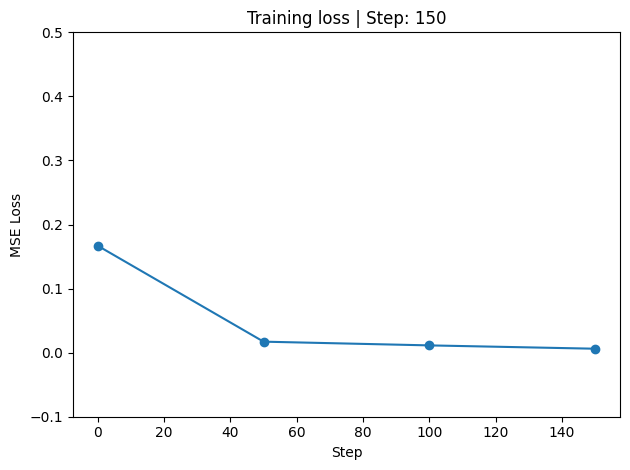

final loss: 0.01


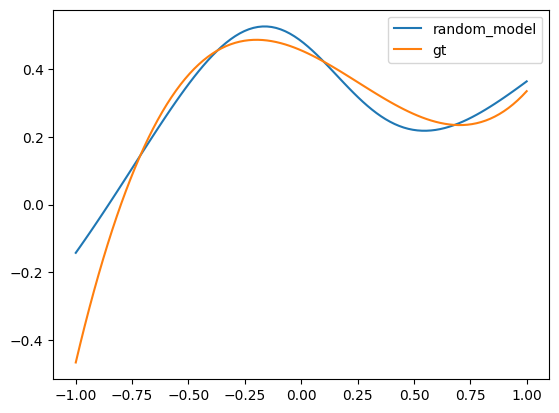

In [95]:
batch_size = 32
hidden_dims=(64, 64)
num_steps = 200
lr=1e-1
random_model, _, random_loss_history = train_polynomial_regressor(
    sample_fn=generator.random_sample,
    batch_size=batch_size,
    num_steps=num_steps,
    hidden_dims=hidden_dims,
    lr=lr,
)

num_points = 100
fig, ax = plt.subplots()
X = generator.get_X(num_points)
Y_random = random_model(X)
ax.plot(X, Y_random, label="random_model")

generator.draw_line(ax=ax, num_points=num_points)
plt.legend(loc="best")
plt.show()


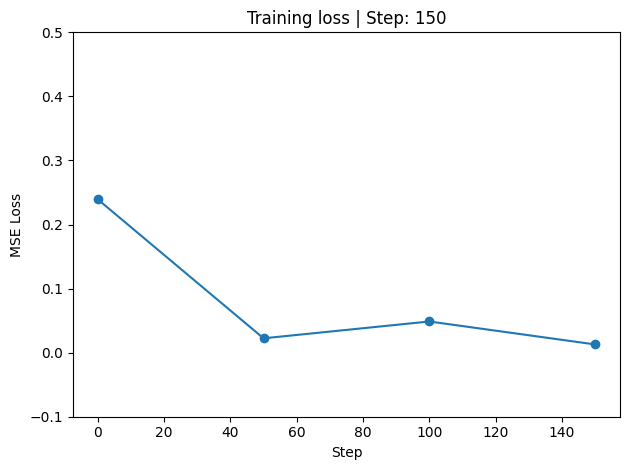

final loss: 0.01


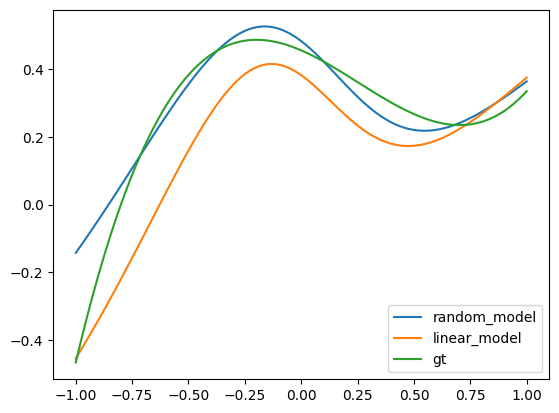

In [97]:
n_seeds = 2
linear_model, _, linear_loss_history = train_polynomial_regressor(
    sample_fn=ft.partial(
        generator.correlated_sample,
        n_seeds=n_seeds,
        linear=True,
        x_range_shrinkage=0.001,
    ),
    batch_size=batch_size,
    num_steps=num_steps,
    hidden_dims=hidden_dims,
    lr=lr,
)
num_points = 100
fig, ax = plt.subplots()
X = generator.get_X(num_points)
Y_random = random_model(X)
ax.plot(X, Y_random, label="random_model")
Y_linear = linear_model(X)
ax.plot(X, Y_linear, label="linear_model")

generator.draw_line(ax=ax, num_points=num_points)
plt.legend(loc="best")
plt.show()


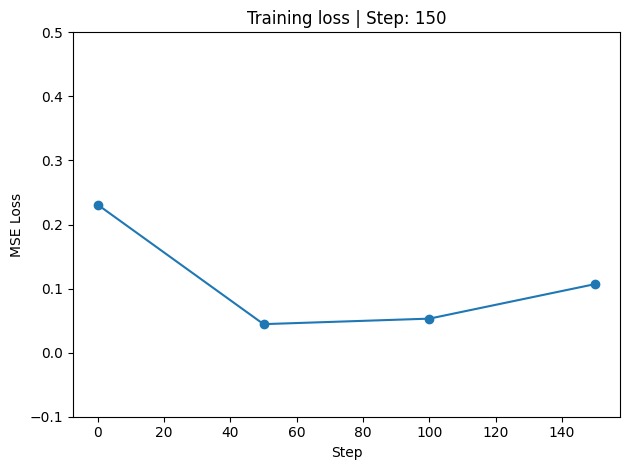

final loss: 0.11


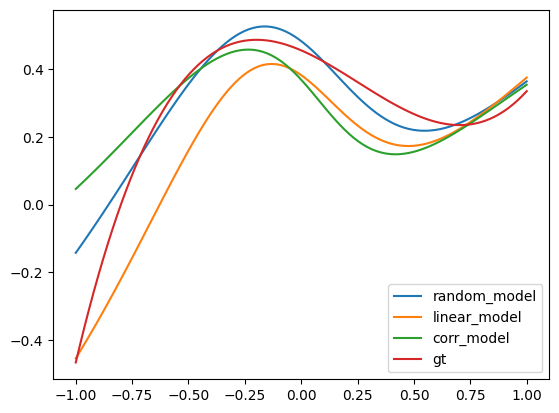

In [98]:

corr_model, _, corr_loss_history = train_polynomial_regressor(
    sample_fn=ft.partial(generator.correlated_sample, n_seeds=n_seeds, linear=False, x_range_shrinkage=0.005),
    batch_size=batch_size,
    num_steps=num_steps,
    hidden_dims=hidden_dims,
    lr=lr,
)

num_points = 100
fig, ax = plt.subplots()
X = generator.get_X(num_points)
Y_random = random_model(X)
ax.plot(X, Y_random, label="random_model")

Y_linear = linear_model(X)
ax.plot(X, Y_linear, label="linear_model")

Y_corr = corr_model(X)
ax.plot(X, Y_corr, label="corr_model")

generator.draw_line(ax=ax, num_points=num_points)
plt.legend(loc="best")
plt.show()
